#### Introduction
Gibbs sampling
- most basic algorithm in Bayesian inference
- applied when it is not possible to simulate from joint posterior distribution of the parameters
- but we can split the posterior distribution into a series of simple conditional distributions
- from which it is easier to generate samples


### Hierarchical model using Gibbs sampling

We have data of number of failures (y$_{i}$) for each of 10 pumps in a nuclear plant. We also have times (i) at which each pump was observed. We want to model the number of failures with Poisson likelihood where expected number of failures (λ$_{i}$) differs for each pump.

We specify a hierarchical model.

The likelihood f is :
\begin{equation}
∏ _{i = 1}^ {10} Poisson\ (λ_{i}\ t_{i})
\end{equation}


we let the prior g for λ be

\begin{equation}
λ ∼ Gamma(α, β)
\end{equation}

with α = 1 and let β be a random variable to be estimated from the data

\begin{equation}
β ∼ Gamma(γ, δ)
\end{equation}

with γ = 0.01 and δ = 1


The posterior is

\begin{equation}
P(λ, β/y, t) = ∏ _{i = 1}^ {10} Poisson\ (λ_{i}\ t_{i})\ x \ Gamma(α, β)\ x \ Gamma(γ, δ)
\end{equation}

with conditional distributions needed for gibbs sampling

\begin{equation}
P(λ/β, y, t) = Gamma(y_{i} + α , t_{i} + β)
\end{equation}

and

\begin{equation}
P(β / λ, y, t) = Gamma(10α + γ, δ + ∑_{i = 1}^{10} λ_{i})
\end{equation}



#### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.stats import gamma
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
np.random.seed(42)


#### Given data

In [ ]:
#pump
pump = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10]

# Number of failures
failures = [5, 1, 5, 14, 3, 19, 1, 1, 4, 22]

# Observation time
obs_time = [94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48]


#### Run Gibbs sampler

In [ ]:
n_iter = 50000

# Initialize the hyperparameters
alpha = 1
delta = 1
gamma_0 = 0.01

beta = np.random.gamma(gamma_0, delta)
lambdas = np.random.gamma(alpha, 1/beta, size = len(obs_time))

lambdas_samples = []
beta_samples = []

# Run the Gibbs sampler
for i in range(n_iter):
    for j in range(len(obs_time)):
      lambdas[j] = np.random.gamma(failures[j] + alpha, 1/(obs_time[j] + beta))
    beta = np.random.gamma(10 * alpha + 0.01, 1/(delta + sum(lambdas)))
    lambdas_samples.append(lambdas.copy())
    beta_samples.append(beta)


#### Trace plot
A traces plot shows the values of the parameters at each iteration of the Gibbs sampler. This can be used to visualize the convergence of the sampler and to identify any problems with convergence. To create a traces plot, you can extract the values of the parameters at each iteration of the sampler and plot them over time. If the traces plot shows the parameter values stabilizing over time, this may indicate that the sampler has converged.

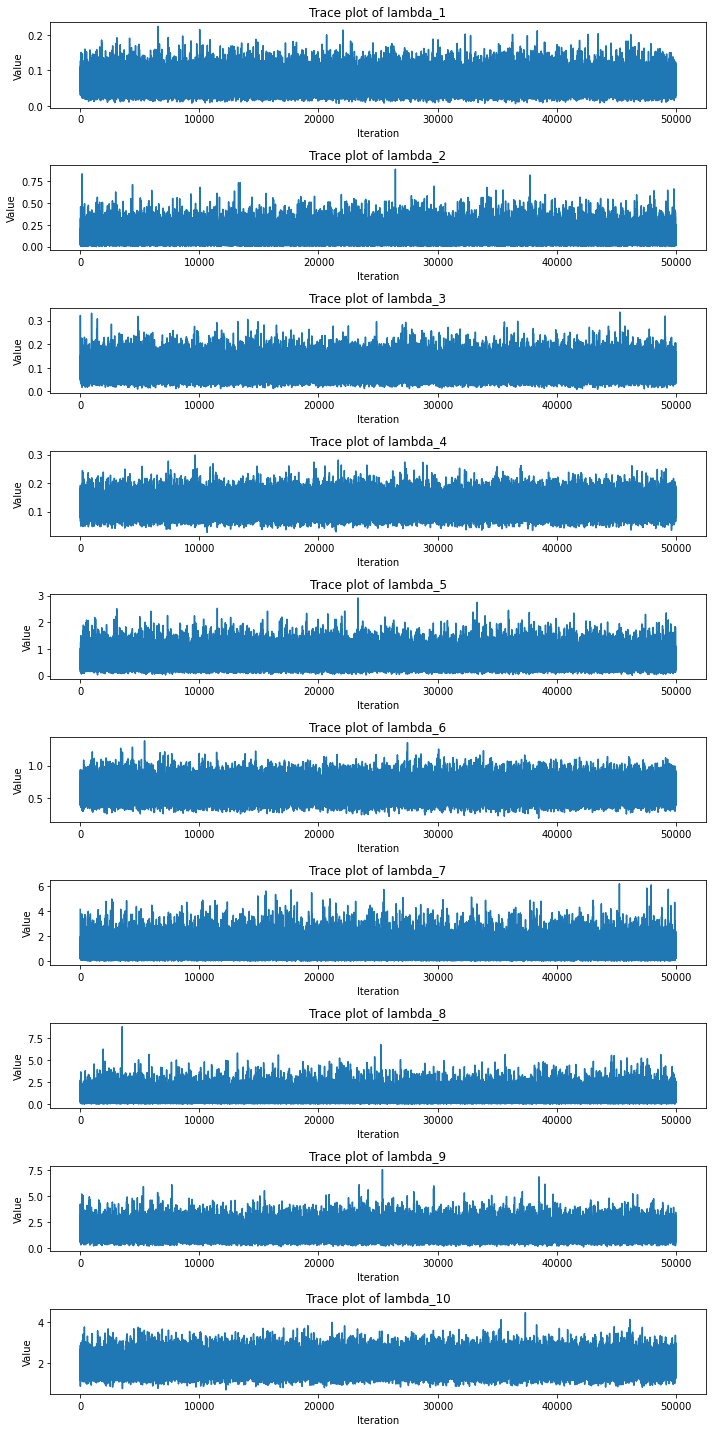

In [ ]:
# Create a figure with len(lambdas) subplots
fig, axs = plt.subplots(len(lambdas), 1, figsize=(10, 20))

# Plot the trace plot of each lambda parameter in a separate subplot
for i in range(len(lambdas)):
    axs[i].plot(list(map(lambda x: x[i], lambdas_samples)))
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Value')
    axs[i].set_title('Trace plot of lambda_{}'.format(i+ 1))

plt.tight_layout()
plt.show()

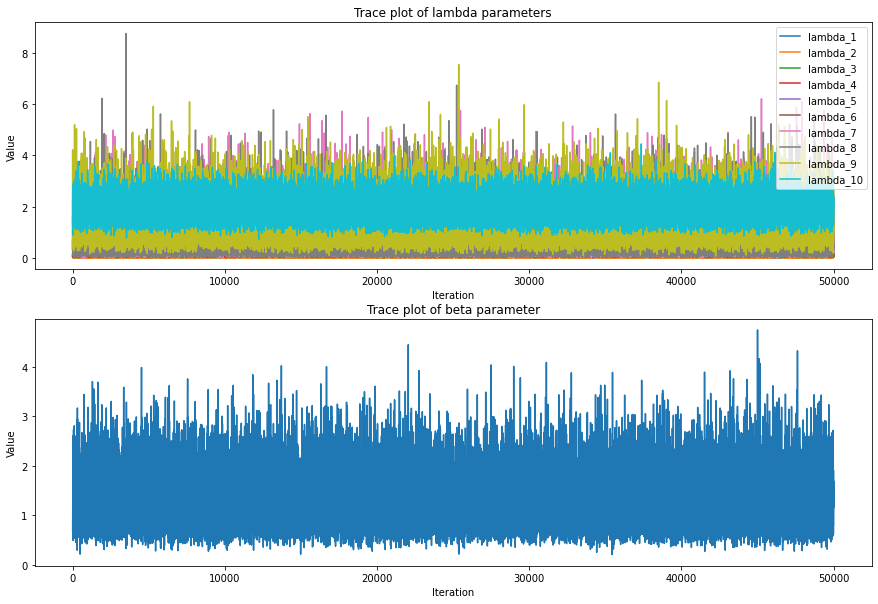

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot the trace plot of the lambda parameters in the first subplot
for j in range(len(lambdas)):
    axs[0].plot(list(map(lambda x: x[j], lambdas_samples)), label='lambda_{}'.format(j+ 1))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].set_title('Trace plot of lambda parameters')

# Plot the trace plot of the beta parameter in the third subplot
axs[1].plot(beta_samples)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Value')
axs[1].set_title('Trace plot of beta parameter')
plt.show()



In [ ]:
# convert the lambdas_samples list of arrays to a 2D array
lambdas_samples_2d = np.array(lambdas_samples).T


#### Density plot

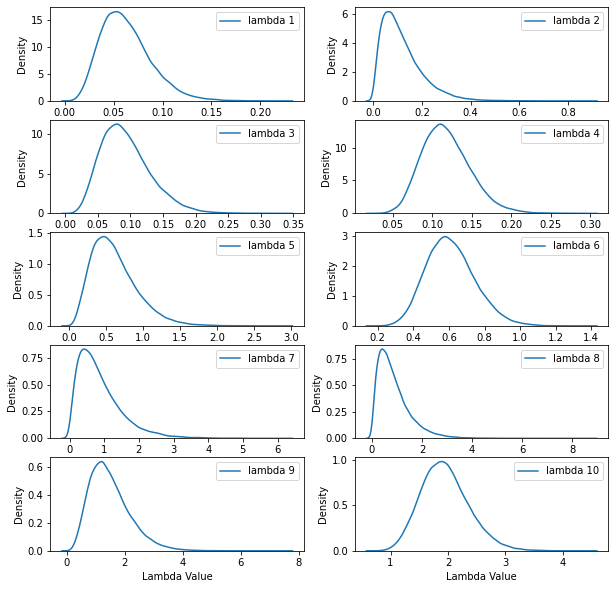

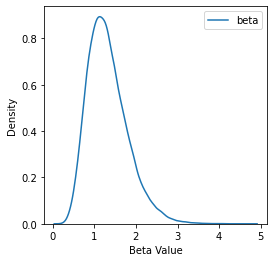

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.ravel()

for i in range(len(pump)):
    sns.kdeplot(lambdas_samples_2d[i], label=f'lambda {i+ 1}',ax=axes[i])
    axes[i].set_xlabel('Lambda Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()


# Create a figure and axes for beta
fig2, ax2 = plt.subplots(figsize=(4, 4))
sns.kdeplot(beta_samples, label='beta',ax=ax2)
ax2.set_xlabel('Beta Value')
ax2.set_ylabel('Density')
ax2.legend()
plt.show()


#### Histogram of parameters

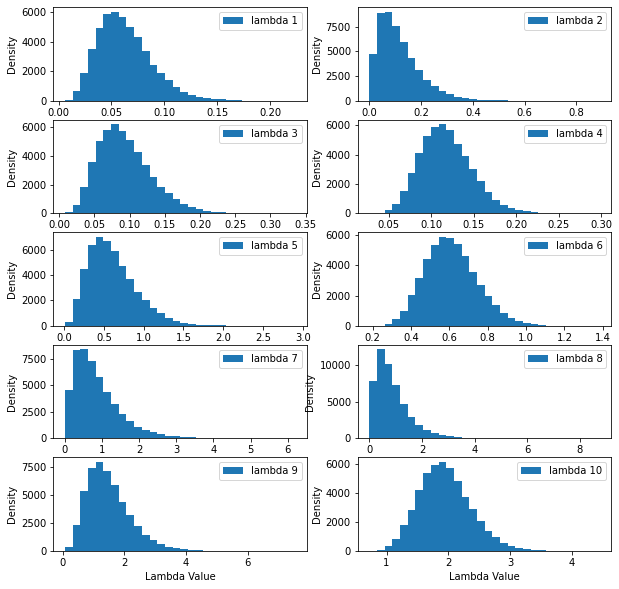

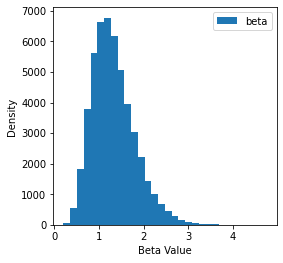

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
axes = axes.ravel()

for i in range(len(pump)):
    axes[i].hist(lambdas_samples_2d[i], bins = 30, label=f'lambda {i + 1}')
    axes[i].set_xlabel('Lambda Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()


# Create a figure and axes for beta
fig2, ax2 = plt.subplots(figsize=(4, 4))
plt.hist(beta_samples, bins = 30, label='beta')
ax2.set_xlabel('Beta Value')
ax2.set_ylabel('Density')
ax2.legend()
plt.show()


#### Calculate summary statistics

In [ ]:
lambdas_df = pd.DataFrame(lambdas_samples_2d.T, columns=[f'lambda {i+ 1}' for i in range(len(pump))])
betas_df = pd.DataFrame(beta_samples, columns = ["beta"])
print(betas_df.describe())
print(lambdas_df.describe())


               beta
count  50000.000000
mean       1.324104
std        0.483666
min        0.203142
25%        0.975394
50%        1.257437
75%        1.601182
max        4.746426
           lambda 1      lambda 2      lambda 3      lambda 4      lambda 5  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.062800      0.117804      0.093230      0.117887      0.612689   
std        0.025700      0.083627      0.038009      0.030521      0.308479   
min        0.005969      0.000468      0.008149      0.027328      0.011758   
25%        0.044084      0.056463      0.065463      0.096113      0.386644   
50%        0.059329      0.098567      0.088054      0.115123      0.561667   
75%        0.077642      0.158267      0.115403      0.136814      0.782735   
max        0.224249      0.890699      0.335603      0.298153      2.908399   

           lambda 6      lambda 7      lambda 8      lambda 9     lambda 10  
count  50000.000000  50000.000

#### Autocorrelation plot

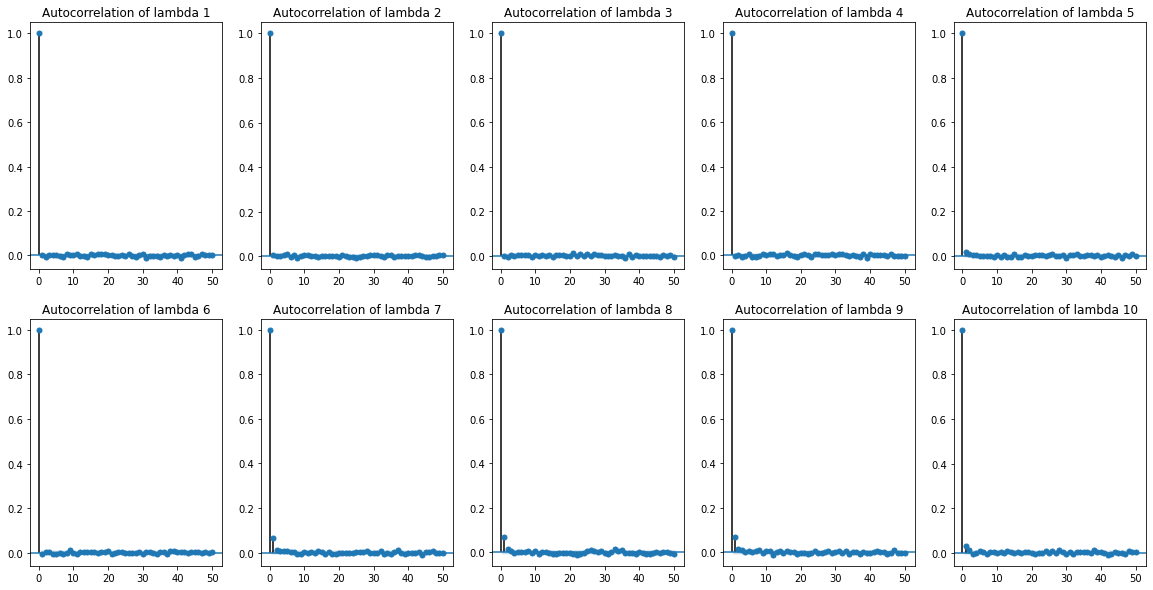

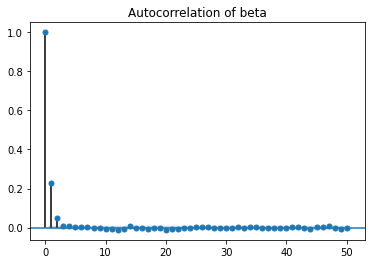

In [ ]:
# assuming you have a 2-d array of lambda samples, where each row represents the samples for a particular lambda
#lambdas_samples_2d = ...

# Plot the autocorrelation for each lambda parameter
fig, axes = plt.subplots(2, 5,  figsize=(20, 10))
axes = axes.ravel()

for i in range(len(pump)):
    plot_acf(lambdas_samples_2d[i], lags=50, ax=axes[i])
    axes[i].set_title(f'Autocorrelation of lambda {i+1}')

plot_acf(beta_samples, lags=50)
plt.title("Autocorrelation of beta")

plt.show()


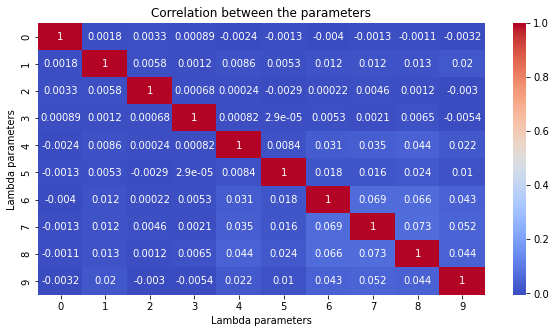

In [ ]:
plt.figure(figsize = (10, 5))
corr = np.corrcoef(lambdas_samples_2d)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between the parameters")
plt.xlabel("Lambda parameters")
plt.ylabel("Lambda parameters")

plt.show()
